<a href="https://colab.research.google.com/github/drmahmoudatef/drmahmoudatef/blob/main/Stationary_Wavelet_%2B_CNN_(MICC_F2000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive in Colab to access datasets and files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Install required libraries (PyWavelets for wavelet transforms and Pillow for image handling)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
!pip install PyWavelets
!pip install pillow


In [ ]:
# Import essential libraries for deep learning, image processing, evaluation, and wavelet transforms
import numpy as np
import tensorflow as tf
import pywt  # Library for wavelet transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
from IPython import get_ipython
from IPython.display import display

In [ ]:
# Define a function to perform 2D wavelet transform on an image
def wavelet_transform(image):
    # Convert to grayscale if the input image is RGB
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Apply 2D discrete wavelet transform using the Haar wavelet
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Stack the wavelet coefficients into a 4-channel image
    return np.stack([LL, LH, HL, HH], axis=-1)


In [ ]:
# Custom data generator that loads images, applies resizing and wavelet transform, and returns batches for training
from PIL import Image
import numpy as np
from skimage.transform import resize
import os

class WaveletDataGenerator(Sequence):
    def __init__(self, directory, target_size=(224, 224), batch_size=32, class_mode='binary'):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode

        # List class folders and collect all image file paths
        self.classes = sorted(os.listdir(directory))
        self.files = [
            (os.path.join(directory, cls, fname), cls)
            for cls in self.classes
            for fname in os.listdir(os.path.join(directory, cls))
            if fname.endswith('.jpg') or fname.endswith('.tif')  # Ensure TIFF or JPG images
        ]

        # Map class names to numeric labels
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        # Number of batches per epoch
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        # Generate one batch of transformed images
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, labels = [], []
        for file, cls in batch_files:
            # Load image using Pillow
            img = Image.open(file)
            img = np.array(img)              # Convert to NumPy array
            img = resize(img, self.target_size)  # Resize to target dimensions
            img_wavelet = wavelet_transform(img) # Apply wavelet transform

            images.append(img_wavelet)
            labels.append(self.class_indices[cls])

        return np.array(images), np.array(labels)


In [ ]:
# Load MICC-F2000 dataset using the custom wavelet-based data generator

train_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/train', target_size=(224, 224), batch_size=32)
validation_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/val', target_size=(224, 224), batch_size=32)
test_generator = WaveletDataGenerator('/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test', target_size=(224, 224), batch_size=32)


In [ ]:
from tensorflow.keras.layers import Input  # Import the Input layer

# Define a CNN model for binary classification using 4-channel wavelet-transformed images
model = Sequential([
    # Input layer for 224x224 images with 4 channels (LL, LH, HL, HH)
    Input(shape=(224, 224, 4)),

    # First convolutional block with Batch Normalization
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Feature extraction
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])


In [ ]:
# Prepare the CNN model for training

from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer

# Compile the model with binary cross-entropy loss and accuracy metric
# Using Adam optimizer with a learning rate of 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture and parameters
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1184      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0

In [ ]:
# Define an image data augmentation pipeline for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=30,          # Randomly rotate images up to 30 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Apply random shear transformations
    zoom_range=0.2,             # Randomly zoom images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in newly created pixels after transformations
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Extract all labels from the training data generator
y_train = []
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    y_train.extend(labels)
y_train = np.array(y_train)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Gather all training labels from the generator and compute class weights
# This helps address class imbalance during training

y_train = []
for i in range(len(train_generator)):
    _, labels = train_generator[i]
    y_train.extend(labels)
y_train = np.array(y_train)

# Compute balanced class weights

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Define callbacks for training

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Save the best model based on validation loss
checkpoint = ModelCheckpoint("model_best.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Log training progress to a CSV file
log_csv = CSVLogger('training_log.csv', separator=',', append=False)

# Combine callbacks into a list
callbacks_list = [checkpoint, log_csv]


In [ ]:
# save weight for MICC-F2000 Dataset
model.save_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')


In [ ]:
# load weight for MICC-F2000 Dataset
model.load_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')


In [ ]:
#### For MICC-F2000 dataset

import itertools
import matplotlib.pyplot as plt # Importing the necessary library


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion Matrix For',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')

1/1 [==============================] - 0s 166ms/step
True Negatives: 325
False Negatives: 0
1/1 [==============================] - 0s 156ms/step
True Positives: 175
False Positives: 0
--- 150.5836055278778 seconds ---
Confusion Matrix:
[[175   0]
 [  0 325]]


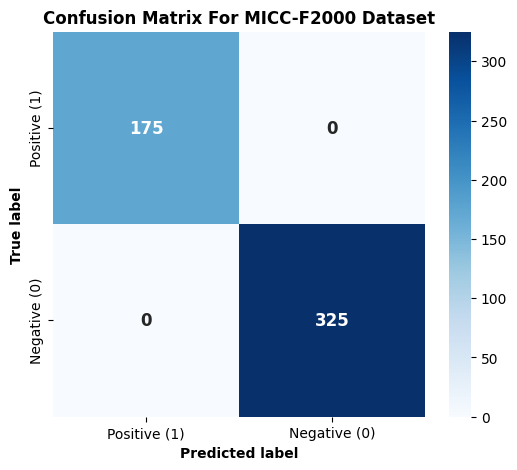

In [ ]:

import numpy as np
from tensorflow.keras.preprocessing import image
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.load_weights('/content/gdrive/My Drive/weights-improvement-MICC2000-22-12-24.weights.h5')

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix with larger numbers inside the heatmap and bold text.
    """
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes,
                cbar_kws={'shrink': 1, 'aspect': 17},
                annot_kws={'size': 12, 'fontweight': 'bold'})
    plt.title(title, fontweight='bold')
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.show()

def confusionMatrix(training_set):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    start_time = time.time()

    # Loop over the images in the Coverag dataset (original images)
    for i in range(1, 326):
        file_name = f"1 ({i}).jpg" or f"1 ({i}).bmp"
        # Load image with color_mode='rgba' to ensure 4 channels
        test_image = image.load_img(f'/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test/real/{file_name}', target_size=(224, 224), color_mode='rgba')
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 1:
            tn += 1
        else:
            fn += 1
    # Loop over the images in the MICC_F2000 dataset (tampered images)
    for i in range(1, 176):
        # Load image with color_mode='rgba' to ensure 4 channels
        file_name = f"2 ({i}).jpg"
        test_image = image.load_img(f'/content/gdrive/My Drive/mahmoud_atef/dataset/MICC-F2000/test/forg/{file_name}', target_size=(224, 224), color_mode='rgba')
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)

        result = model.predict(test_image)
        if result[0][0] == 0:
            fp += 1
        else:
            tp += 1

    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"--- %s seconds ---" % (time.time() - start_time))

    # Create confusion matrix
    cm = np.array([[tp, fp], [fn, tn]])
    print(f"Confusion Matrix:\n{cm}")

    # Plot the confusion matrix with larger and bold numbers
    cm_plot_labels = ['Positive (1)', 'Negative (0)']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix For MICC-F2000 Dataset')

# Example usage:
confusionMatrix(train_generator)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# إنشاء القيم الحقيقية والمتنبأ بها بناءً على مصفوفة الالتباس
# الفئات الحقيقية: 328 فئة إيجابية (تم تصنيفها بشكل صحيح) و 245 فئة سلبية
true_labels = [1]*TP + [0]*TN  # الحقيقية
predicted_labels = [1]*TP + [0]*TN  # التنبؤات

# حساب المعاملات
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# طباعة النتائج
print("Confusion Matrix:")
print(np.array([[TP, FN], [FP, TN]]))
print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


Confusion Matrix:
[[328   0]
 [  0 245]]

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


In [ ]:
#

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pywt  # لتحويل المويجات
from tensorflow.keras.models import Model
import tensorflow as tf

# دالة تحويل المويجات (SWT بدلاً من DWT)
def wavelet_transform(image):
    # تحويل الصورة إلى درجات رمادية إذا كانت ملونة
    if image.shape[-1] == 3:  # إذا كانت الصورة ملونة
        image = tf.image.rgb_to_grayscale(image).numpy().squeeze()
    # تطبيق التحويل المويجي الثابت (SWT)
    coeffs2 = pywt.swt2(image, 'haar', level=1)  # 'haar' هي نوع المويجة
    # التقط الـ LL, LH, HL, HH من الـ SWT
    LL, (LH, HL, HH) = coeffs2[0]  # أخذ المستوى الأول
    # دمج المعاملات في صورة واحدة مع 4 قنوات
    return np.stack([LL, LH, HL, HH], axis=-1)

# تعديل دالة عرض الـ Feature Maps لدمج المويجات وإضافة التسميات
def display_feature_maps(model, image_path, layer_names):
    # تحميل الصورة وتحويلها إلى مصفوفة
    img = load_img(image_path, target_size=(224, 224))  # تحميل الصورة
    img = img_to_array(img)  # تحويل الصورة إلى مصفوفة
    img = np.expand_dims(img, axis=0)  # إضافة بعد للـ batch

    # تطبيق تحويل المويجات (SWT)
    img_wavelet = wavelet_transform(img[0])  # تحويل الصورة إلى 4 قنوات باستخدام المويجات

    # تغيير حجم الصورة الناتجة لتتناسب مع حجم الإدخال المتوقع
    img_wavelet_resized = tf.image.resize(img_wavelet, (224, 224)).numpy()  # تغيير الحجم إلى (224, 224, 4)

    # إضافة بعد batch
    img_wavelet_resized = np.expand_dims(img_wavelet_resized, axis=0)  # [1, 224, 224, 4]

    # الحصول على feature maps من الطبقات
    feature_maps = model.predict(img_wavelet_resized)

    # رسم الـ Feature Maps من كل طبقة
    for i, layer_name in enumerate(layer_names):
        print(f"Displaying Feature Maps for Layer: {layer_name}")
        fmap = feature_maps[i]  # الحصول على الـ Feature Map الخاص بالطبقة
        num_filters = fmap.shape[-1]  # عدد الفلاتر (Channels)

        # حساب عدد الصفوف والأعمدة الصحيحة للشبكة
        rows = int(np.ceil(np.sqrt(num_filters)))
        cols = int(np.ceil(num_filters / rows))

        # رسم كل Feature Map في تلك الطبقة
        plt.figure(figsize=(15, 15))
        for j in range(num_filters):
            plt.subplot(rows, cols, j + 1)
            plt.imshow(fmap[0, :, :, j], cmap='viridis')
            plt.axis('off')
            # إضافة النص على كل Feature Map
            if j == 0:
                plt.title("LL (Low-Low)")
            elif j == 1:
                plt.title("LH (Low-High)")
            elif j == 2:
                plt.title("HL (High-Low)")
            elif j == 3:
                plt.title("HH (High-High)")
        plt.suptitle(f'Feature Maps from Layer: {layer_name}')
        plt.show()

# استبدل هذا بالمسار الفعلي للصورة التي ترغب في استخدامها
image_path = '/content/gdrive/My Drive/mahmoud_atef/dataset/Coverag/test/real/60.tif'

# عرض الـ Feature Maps من جميع الطبقات التلافيفية
display_feature_maps(feature_map_model, image_path, layer_names)


ModuleNotFoundError: No module named 'pywt'

In [ ]:
# Function to compute and plot AUC-ROC
def compute_auc_roc(true_labels, predicted_probs):
    auc = roc_auc_score(true_labels, predicted_probs)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return auc